# SageMaker Model Training and Prediction
## Introduction
__"Leverage SageMaker from Notebook --> Production Testing"__

---
## 1 - Model Training
### Permissions and Environmental Variables

In [1]:
# Import libraries
#from __future__ import print_function
import os
import io
import boto3
import sagemaker
import h5py
import json
import numpy as np
import mxnet as mx
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

# Confifuree SageMaker
sagemaker_session = sagemaker.Session()
role = get_execution_role()

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Input Data Preparation

In [2]:
# Create local repository for Numpy Arrays
if not os.path.exists('/tmp/data'):
    os.mkdir('/tmp/data')

# Load the Training and Testing dataset
dataset = h5py.File('datasets/datasets.h5', 'r')

# Save the Dataset as Numpy Arrays
np.save('/tmp/data/train_X.npy', np.array(dataset['train_set_x'][:]))
np.save('/tmp/data/train_Y.npy', np.array(dataset['train_set_y'][:]))
np.save('/tmp/data/test_X.npy', np.array(dataset['test_set_x'][:]))
np.save('/tmp/data/test_Y.npy', np.array(dataset['test_set_y'][:]))

# Upload the Training and Testing Data to S3
inputs = sagemaker_session.upload_data(path='/tmp/data', key_prefix='training_input')
bucket = inputs.split('/')[2]

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-722812380636


## Create the Estimator

In [3]:
# Create a MXNet Estimator
mxnet_estimator = MXNet(
    'model.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    output_path='s3://'+bucket,
    hyperparameters={
        'epochs': 3000,
        'optmizer': 'sgd',
        'learning_rate': 0.0075,
        'batch_size': 64
    }
)

## Train the Model

In [4]:
# Create a new Job name for current training run
job_name = 'itsacat-train-v0-002'
mxnet_estimator.fit(inputs)#, job_name=job_name)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-722812380636
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-04-07-23-25-26-765


.....................................................
2018-04-07 23:29:43,033 INFO - root - running container entrypoint
2018-04-07 23:29:43,033 INFO - root - starting train task
2018-04-07 23:29:43,039 INFO - container_support.training - Training starting
2018-04-07 23:29:45,186 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'model.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'model.py', u'learning_rate': 0.0075, u'batch_size': 64, u'epoch

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sagemaker/session.py:623: DeprecationWarning: generator 'multi_stream_iter' raised StopIteration
  for idx, event in sagemaker.logs.multi_stream_iter(client, log_group, stream_names, positions):


Epoch: 100; Loss: 0.525583180514; Train-accuracy = 0.751196172249; Validation-accuracy = 0.44
Epoch: 200; Loss: 0.25254864898; Train-accuracy = 0.928229665072; Validation-accuracy = 0.66
Epoch: 300; Loss: 0.222262862767; Train-accuracy = 0.913875598086; Validation-accuracy = 0.54
Epoch: 400; Loss: 0.100113235307; Train-accuracy = 0.985645933014; Validation-accuracy = 0.68
Epoch: 500; Loss: 0.0912205398653; Train-accuracy = 0.985645933014; Validation-accuracy = 0.68
Epoch: 600; Loss: 0.0111475585465; Train-accuracy = 0.995215311005; Validation-accuracy = 0.7
Epoch: 700; Loss: 0.00653851233672; Train-accuracy = 0.995215311005; Validation-accuracy = 0.7
Epoch: 800; Loss: 0.00328767116061; Train-accuracy = 1.0; Validation-accuracy = 0.7
Epoch: 900; Loss: 0.00146756576971; Train-accuracy = 1.0; Validation-accuracy = 0.74
Epoch: 1000; Loss: 0.00104761558126; Train-accuracy = 1.0; Validation-accuracy = 0.74
Epoch: 1100; Loss: 0.00082983147647; Train-accuracy = 1.0; Validation-accuracy = 0.74


---
## 2 - Training Analysis

Model Training Time: 3 Minute(s)


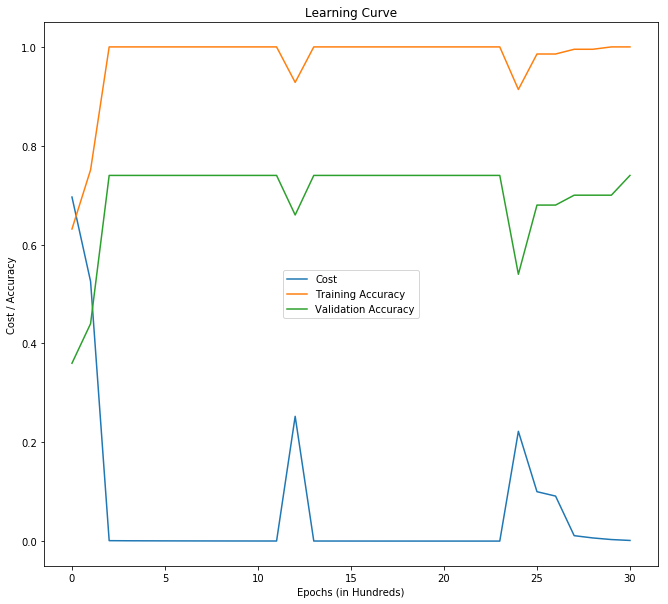

In [5]:
# Download and uncompress output results from model training
import tarfile, datetime
import matplotlib.pyplot as plt
%matplotlib inline
job_name = 'sagemaker-mxnet-2018-04-07-23-25-26-765'
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(job_name+'/output/output.tar.gz', '/tmp/output.tar.gz')
tarfile.open('/tmp/output.tar.gz').extractall()
with open('results.json') as j:
    data = json.load(j)#, object_pairs_hook=OrderedDict)

# Format data for plotting
costs = []
val_acc = []
train_acc = []
# Python2
#for key, value in sorted(data.iteritems(), key=lambda (k,v): (v, k)):
#Python3
for key, value in sorted(data.items()):#, key=lambda (k,v): (v, k)):
    if 'epoch' in key:
        for k, v in value.items():
            if k == 'cost':
                costs.append(v)
            elif k == 'val_acc':
                val_acc.append(v)
            elif k == 'train_acc':
                train_acc.append(v)
    elif 'Start' in key:
        start = datetime.datetime.strptime(value, "%Y-%m-%d %H:%M:%S.%f")
    elif 'End' in key:
        end = datetime.datetime.strptime(value, "%Y-%m-%d %H:%M:%S.%f")

#val_acc.reverse()
val_acc = np.array(val_acc)
#train_acc.reverse()
train_acc = np.array(train_acc)
#costs.reverse()
costs = np.array(costs)
delta = end - start
print("Model Training Time: {} Minute(s)".format(int(delta.total_seconds() / 60)))

# Plot the Learning Curve
plt.rcParams['figure.figsize'] = (11.0, 10.0)
plt.plot(costs)
plt.plot(train_acc)
plt.plot(val_acc)
plt.ylabel('Cost / Accuracy')
plt.xlabel('Epochs (in Hundreds)')
plt.title("Learning Curve")
plt.legend(['Cost', 'Training Accuracy', 'Validation Accuracy'])
plt.show;

---
## 3 - Prediciton Analysis

In [6]:
predictor = mxnet_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-04-07-23-25-26-765
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-04-07-23-25-26-765


--------------------------------------------------------------!

__Test prediction on local images__

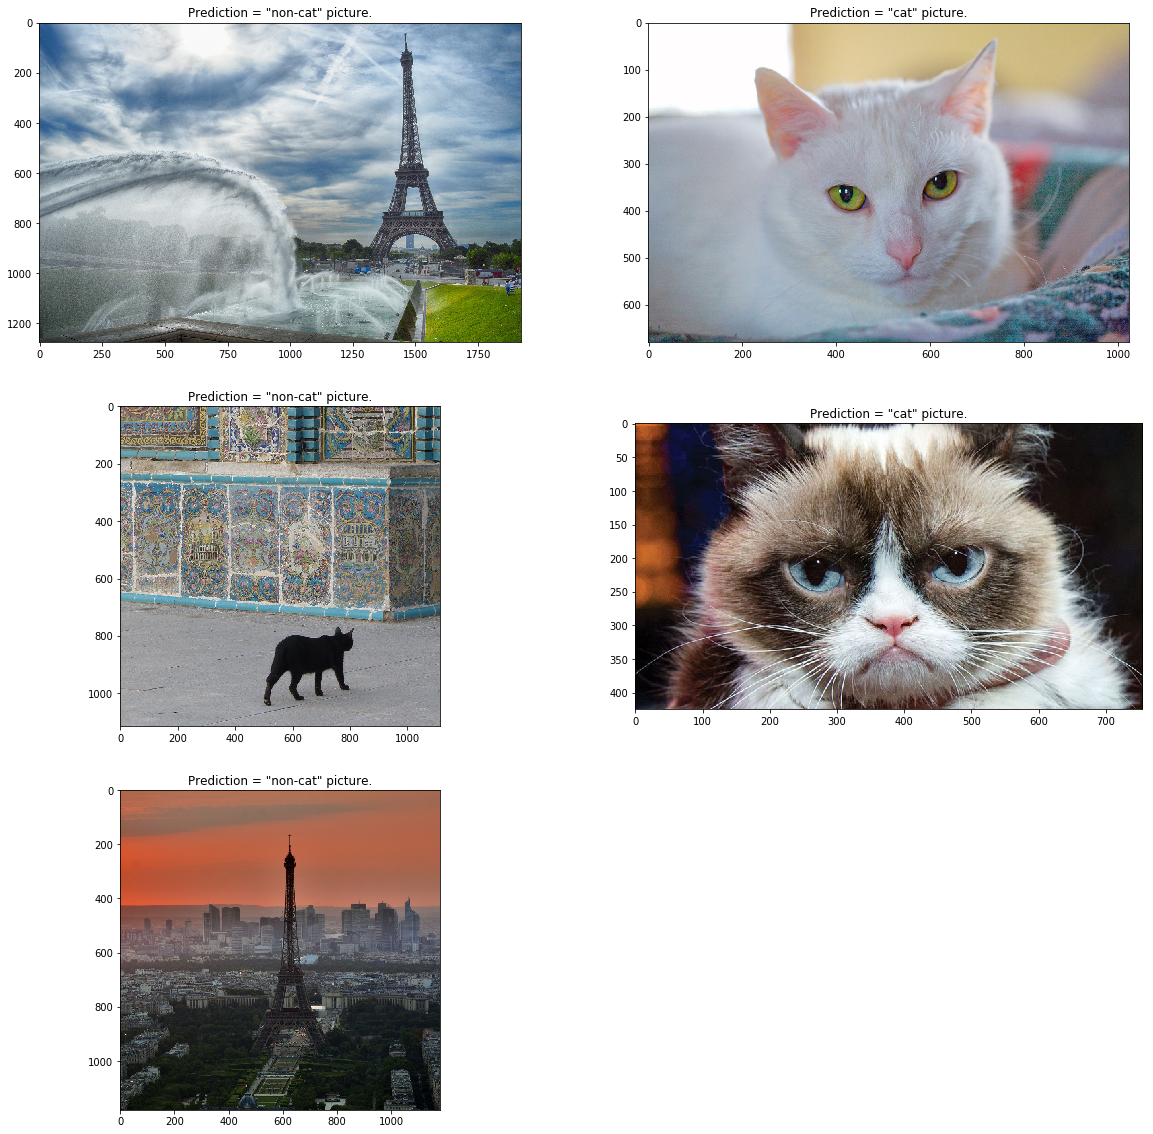

In [7]:
import glob
import matplotlib.image as mpimg
from skimage import transform
%matplotlib inline

# Get Classes
classes = ["non-cat", "cat"]

# Get Image files
images = []
for img_path in glob.glob('./images/*'):
    images.append(mpimg.imread(img_path))

# Plot predictions
plt.figure(figsize=(20.0,20.0))
columns = 2
for i, image in enumerate(images):
    img = transform.resize(image, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
    prediction = int(predictor.predict(img.tolist()))
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title('Prediction = "{}" picture.'.format(classes[prediction]))
    plt.imshow(image);

__Simulate Prediciton Application__

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Prediction = "non-cat" picture.


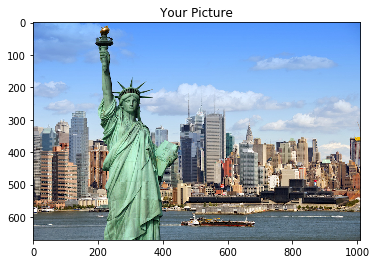

In [8]:
# Function to process image url
import urllib3
import io
#from cStringIO import StringIO
import json
from PIL import Image
from skimage import transform

def process_url(url):
    """
    Retrieves image from a URL and converts the image
    to a Numpy Array as the Payload for the SageMaker
    hosted endpoint.
    
    Arguments:
    url -- Full URL of the image
    
    Returns:
    payload -- Preprocessed image as a numpy array and returns a list
    """
    http = urllib3.PoolManager()
    req = http.request('GET', url)
    image = np.array(Image.open(io.BytesIO(req.data)))
    result = transform.resize(image, (64, 64), mode='constant').reshape((1, 64 * 64 * 3))
    return image, result.tolist()

# Create the payload for the endpoint
runtime = boto3.client(service_name='runtime.sagemaker')
url = 'https://www.housingwire.com/ext/resources/images/editorial/A-New-Big-Images/states/New-York-City.jpg?1453402066'
image, payload = process_url(url)

# Invoke the SageMaker endpoint
response = runtime.invoke_endpoint(
    EndpointName=job_name,
    ContentType='application/json',
    Body=json.dumps(payload)
)

# Format the prediction
classes = ['non-cat', 'cat']
prediction = classes[int(json.loads(response['Body'].read().decode('utf-8')))]

# Display results
print('Prediction = \"'+prediction+'\" picture.')
plt.title("Your Picture")
plt.imshow(image);